In [45]:
## check colab GPU
import tensorflow as tf
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [46]:
## comaprison between CPU vs GPU

%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.4440496470001563
GPU (s):
0.10706212900004175
GPU speedup over CPU: 32x


In [113]:
import glob
import os
import tensorflow as tf
import cv2
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [75]:
## base model definition
## EPOCHS 100 to see the initial output
EPOCHS = 100

## Dataset path
DATASET_PATH = '/content/drive/MyDrive/IOD/dataset/base'

## Result path
RESULT_PATH = '/content/drive/MyDrive/IOD/results/'

In [58]:
## Simple Sequential CNN, input with grayscale shape

def Model():
    return Sequential([Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)), 
                       MaxPool2D(),
                       Conv2D(64, (3, 3), activation='relu'),
                       MaxPool2D(),
                       Conv2D(128, (3, 3), activation='relu'),
                       MaxPool2D(),
                       Conv2D(256, (3, 3), activation='relu'),
                       MaxPool2D(),
                       Flatten(),
                       Dense(1, activation='sigmoid')])

In [52]:
## Build image Dataset using keras.preprocessing.image_dataset_from_directory function
## Label the Non Defect images = 0, Defect = 1, automatically encoded using lables = 'inferred'
## Training set 70%, validation set 30%

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    labels  = 'inferred', 
    label_mode= 'int',
    shuffle=True,
    seed=123,
    validation_split=0.3,
    color_mode='grayscale',
    subset='training',
)
ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    labels = 'inferred', 
    label_mode= 'int',
    shuffle=True,
    seed=123,
    validation_split=0.3,
    color_mode='grayscale',
    subset='validation'
)

Found 945 files belonging to 2 classes.
Using 662 files for training.
Found 945 files belonging to 2 classes.
Using 283 files for validation.


In [76]:
## Compile model
model = Model()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [60]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_104 (Conv2D)          (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 28, 28, 256)      

In [77]:
## Train the model, and passing earlystopping callback to stop if val_loss is not improving over given patience time

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=2)

history = model.fit(ds_train, validation_data=ds_validation, epochs=EPOCHS, callbacks=[earlystopping])

Epoch 1/100
21/21 [==============================] - 4s 201ms/step - loss: 7.4388 - accuracy: 0.7810 - val_loss: 0.5803 - val_accuracy: 0.8693
Epoch 2/100
21/21 [==============================] - 4s 186ms/step - loss: 0.4799 - accuracy: 0.8550 - val_loss: 0.3478 - val_accuracy: 0.8799
Epoch 3/100
21/21 [==============================] - 4s 184ms/step - loss: 0.3504 - accuracy: 0.8776 - val_loss: 0.3363 - val_accuracy: 0.8940
Epoch 4/100
21/21 [==============================] - 4s 183ms/step - loss: 0.3327 - accuracy: 0.8792 - val_loss: 0.3485 - val_accuracy: 0.8622
Epoch 5/100
21/21 [==============================] - 4s 181ms/step - loss: 0.3454 - accuracy: 0.8776 - val_loss: 0.3301 - val_accuracy: 0.8869
Epoch 6/100
21/21 [==============================] - 4s 185ms/step - loss: 0.3338 - accuracy: 0.8822 - val_loss: 0.3323 - val_accuracy: 0.8940
Epoch 7/100
21/21 [==============================] - 4s 183ms/step - loss: 0.3390 - accuracy: 0.8792 - val_loss: 0.3613 - val_accuracy: 0.8693

In [78]:
score = model.evaluate(ds_validation, batch_size = 10)

9/9 [==============================] - 0s 26ms/step - loss: 0.5054 - accuracy: 0.8693


In [79]:
## Save the prediction outputs and save images to results folder
## This code also to be used to caculate the confusion matrix, as the dataset was prebuild and batched, not able to extract the labels in correct order

def mkdir(path):
    if os.path.exists(path) is False:
        os.mkdir(path)
mkdir(RESULT_PATH)
mkdir(RESULT_PATH + '/TP')
mkdir(RESULT_PATH + '/TN')
mkdir(RESULT_PATH + '/FP')
mkdir(RESULT_PATH + '/FN')

index = 0
for imgs, labels in ds_validation:
    preds = model.predict(imgs)
    # print(preds)
    for i in range(imgs.shape[0]):
        target = labels[i].numpy()
        y = preds[i]
        # print(y)
        
        if target == 1 and y > 0.5:
            path = RESULT_PATH + '/TP'
        elif target == 1 and y <= 0.5:
            path = RESULT_PATH + '/FN'
        elif target == 0 and y > 0.5:
            path = RESULT_PATH + '/FP'
        else:
            path = RESULT_PATH + '/TN'
            
        cv2.imwrite(path + '/%.4f_%04d.png' % (y, index), imgs[i].numpy())
        index +=1

In [99]:
## Output lenth check 

TP = len(glob.glob(RESULT_PATH + '/TP/*.png'))
TN = len(glob.glob(RESULT_PATH + '/TN/*.png'))
FP = len(glob.glob(RESULT_PATH + '/FP/*.png'))
FN = len(glob.glob(RESULT_PATH + '/FN/*.png'))

In [114]:
## confusion matrix 
cf_matrix = np.asarray([[TN, FP], [FN, TP]])

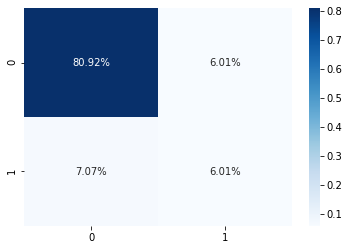

In [117]:
## confusion matrix heatmap
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

In [126]:
accuracy = (TP + TN) / float(TP + TN + FP + FN)
print('Accuracy : {:.2f} '.format(accuracy) )

classification_error = (FP + FN) / float(TP + TN + FP + FN)
print('Classification Error : {:.2f} '.format(classification_error))

sensitivity = TP / float(FN + TP)
print('Recall : {:.2f} '.format(sensitivity))

specificity = TN / (TN + FP)
print('Specificity : {:.2f} '.format(specificity))

print('False Positive Rate : {:.2f} '.format(1 - specificity))

Accuracy : 0.87 
Classification Error : 0.13 
Recall : 0.46 
Specificity : 0.93 
False Positive Rate : 0.07 


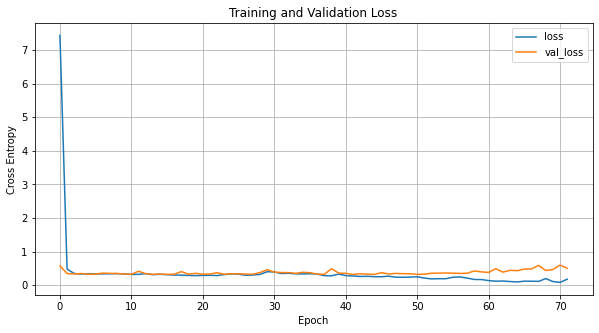

In [96]:
## loss vs val_loss curve

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10,5))
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.grid()
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.show()

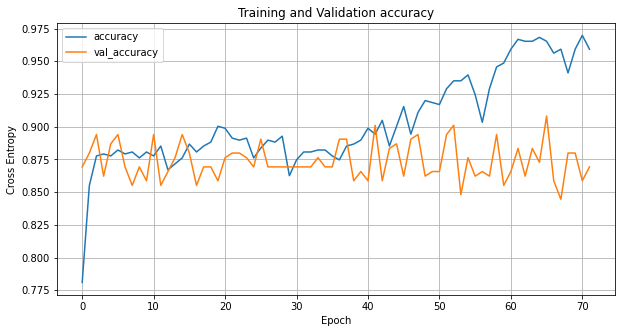

In [95]:
## accuracy vs val_accuracy curve

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(10,5))
plt.plot(accuracy,  label='accuracy')
plt.plot(val_accuracy, label='val_accuracy')
plt.legend()
plt.grid()
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.title('Training and Validation accuracy')
plt.show()